In [1]:
###순환드롭아웃
###스태킹순환층
###양방향순환층

In [2]:
import keras

In [33]:
import os

data_dir = 'C:/Users/Woody/Desktop/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [34]:
import numpy as np
float_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

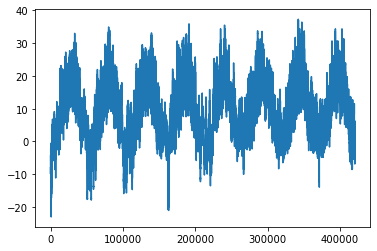

In [35]:
from matplotlib import pyplot as plt

temp = float_data[:, 1]  # 온도(섭씨)
plt.plot(range(len(temp)), temp)
plt.show()

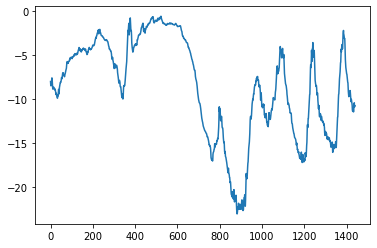

In [36]:
plt.plot(range(1440), temp[:1440])
plt.show()

In [37]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [12]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [38]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=8000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=8001,
                    max_index=16000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=16001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# 전체 검증 세트를 순회하기 위해 val_gen에서 추출할 횟수
val_steps = (24000 - 16001 - lookback) // batch_size

# 전체 테스트 세트를 순회하기 위해 test_gen에서 추출할 횟수
test_steps = (len(float_data) - 24001 - lookback) // batch_size

In [39]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.299691910788131


In [40]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen,
                      steps_per_epoch=500,
                      epochs=10,
                      validation_data=val_gen,
                      validation_steps=val_steps)

Epoch 1/10
500/500 [==============================] - 10s 19ms/step - loss: 0.8068 - val_loss: 0.9726
Epoch 2/10
500/500 [==============================] - 9s 19ms/step - loss: 0.2687 - val_loss: 0.9682
Epoch 3/10
500/500 [==============================] - 8s 17ms/step - loss: 0.1799 - val_loss: 0.9103
Epoch 4/10
500/500 [==============================] - 8s 16ms/step - loss: 0.1404 - val_loss: 0.9215
Epoch 5/10
500/500 [==============================] - 10s 20ms/step - loss: 0.1224 - val_loss: 0.9370
Epoch 6/10
500/500 [==============================] - 8s 16ms/step - loss: 0.1129 - val_loss: 0.9612
Epoch 7/10
500/500 [==============================] - 8s 17ms/step - loss: 0.1048 - val_loss: 0.9246
Epoch 8/10
500/500 [==============================] - 8s 16ms/step - loss: 0.1019 - val_loss: 0.9341
Epoch 9/10
500/500 [==============================] - 8s 16ms/step - loss: 0.0980 - val_loss: 0.9359
Epoch 10/10
500/500 [==============================] - 9s 18ms/step - loss: 0.0961 - val_

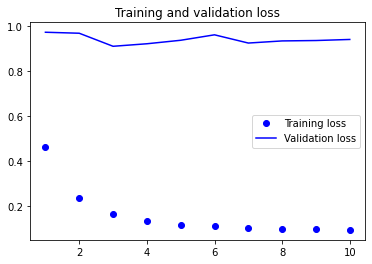

In [41]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [43]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen,
                              steps_per_epoch=300,
                              epochs=10,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/10
300/300 [==============================] - 46s 144ms/step - loss: 0.2559 - val_loss: 0.5094
Epoch 2/10
300/300 [==============================] - 36s 121ms/step - loss: 0.1671 - val_loss: 0.5892
Epoch 3/10
300/300 [==============================] - 33s 109ms/step - loss: 0.1359 - val_loss: 0.5835
Epoch 4/10
300/300 [==============================] - 33s 109ms/step - loss: 0.1195 - val_loss: 0.5723
Epoch 5/10
300/300 [==============================] - 32s 108ms/step - loss: 0.1083 - val_loss: 0.5712
Epoch 6/10
300/300 [==============================] - 37s 124ms/step - loss: 0.0969 - val_loss: 0.5994
Epoch 7/10
300/300 [==============================] - 48s 159ms/step - loss: 0.0885 - val_loss: 0.5735
Epoch 8/10
300/300 [==============================] - 45s 151ms/step - loss: 0.0784 - val_loss: 0.5910
Epoch 9/10
300/300 [==============================] - 35s 116ms/step - loss: 0.0701 - val_loss: 0.5701
Epoch 10/10
300/300 [==============================] - 44s 148ms/step - l

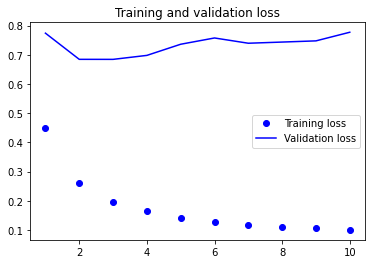

In [27]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [30]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=10,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/10
500/500 [==============================] - 103s 199ms/step - loss: 0.5588 - val_loss: 0.6745
Epoch 2/10
500/500 [==============================] - 77s 153ms/step - loss: 0.3842 - val_loss: 0.7690
Epoch 3/10
500/500 [==============================] - 66s 132ms/step - loss: 0.2754 - val_loss: 0.8022
Epoch 4/10
500/500 [==============================] - 98s 196ms/step - loss: 0.2226 - val_loss: 0.8057
Epoch 5/10
500/500 [==============================] - 69s 138ms/step - loss: 0.1975 - val_loss: 0.8290
Epoch 6/10
500/500 [==============================] - 66s 133ms/step - loss: 0.1775 - val_loss: 0.8224
Epoch 7/10
500/500 [==============================] - 100s 199ms/step - loss: 0.1684 - val_loss: 0.8015
Epoch 8/10
500/500 [==============================] - 96s 191ms/step - loss: 0.1595 - val_loss: 0.7903
Epoch 9/10
500/500 [==============================] - 75s 150ms/step - loss: 0.1539 - val_loss: 0.7756
Epoch 10/10
500/500 [==============================] - 99s 198ms/step -

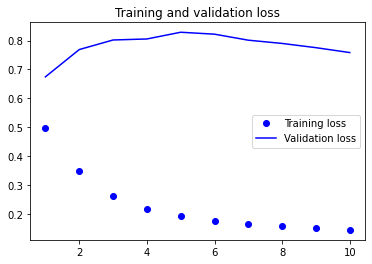

In [31]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [44]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000  # 특성으로 사용할 단어의 수
max_len = 500  # 사용할 텍스트의 길이(가장 빈번한 max_features 개의 단어만 사용합니다)

print('데이터 로드...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), '훈련 시퀀스')
print(len(x_test), '테스트 시퀀스')

print('시퀀스 패딩 (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
print('x_train 크기:', x_train.shape)
print('x_test 크기:', x_test.shape)

데이터 로드...


<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\Woody\anaconda3\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
C:\Users\Woody\anaconda3\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant

25000 훈련 시퀀스
25000 테스트 시퀀스
시퀀스 패딩 (samples x time)
x_train 크기: (25000, 500)
x_test 크기: (25000, 500)


In [45]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 128)          1280000   
_________________________________________________________________
conv1d (Conv1D)              (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 98, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable params: 0
___________________________________________

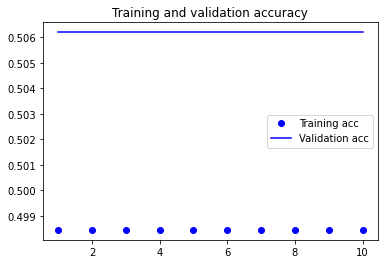

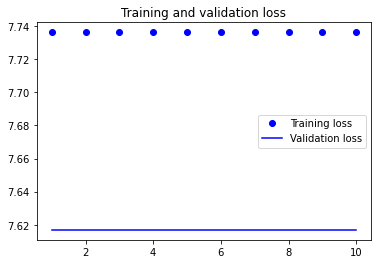

In [46]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [48]:
import os
import numpy as np

data_dir = 'C:/Users/Woody/Desktop/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
    
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets
        
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# 전체 검증 세트를 순회하기 위해 val_gen에서 추출할 횟수
val_steps = (300000 - 200001 - lookback) // batch_size

# 전체 테스트 세트를 순회하기 위해 test_gen에서 추출할 횟수
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [49]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 49s 96ms/step - loss: 0.4671 - val_loss: 0.4407
Epoch 2/20
500/500 [==============================] - 40s 80ms/step - loss: 0.3691 - val_loss: 0.4418
Epoch 3/20
500/500 [==============================] - 39s 78ms/step - loss: 0.3454 - val_loss: 0.4335
Epoch 4/20
500/500 [==============================] - 39s 78ms/step - loss: 0.3258 - val_loss: 0.4450
Epoch 5/20
500/500 [==============================] - 40s 80ms/step - loss: 0.3182 - val_loss: 0.4357A: 0s - loss: 
Epoch 6/20
500/500 [==============================] - 39s 79ms/step - loss: 0.3051 - val_loss: 0.4564
Epoch 7/20
500/500 [==============================] - 44s 87ms/step - loss: 0.2960 - val_loss: 0.4430
Epoch 8/20
500/500 [==============================] - 46s 92ms/step - loss: 0.2902 - val_loss: 0.4651
Epoch 9/20
500/500 [==============================] - 43s 86ms/step - loss: 0.2831 - val_loss: 0.4624
Epoch 10/20
500/500 [==============================] - 46s 92ms/step

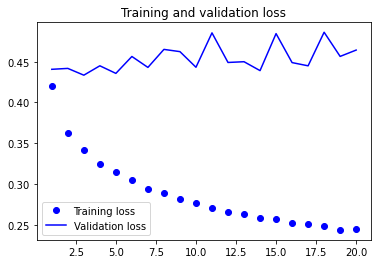

In [50]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [51]:
# 이전에는 6이었습니다(시간마다 1 포인트); 이제는 3 입니다(30분마다 1 포인트)
step = 3
lookback = 1440  # 변경 안 됨
delay = 144 # 변경 안 됨

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step)
val_steps = (300000 - 200001 - lookback) // 128
test_steps = (len(float_data) - 300001 - lookback) // 128

In [52]:
model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=10,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
gru_6 (GRU)                  (None, 32)                6336      
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 33        
Total params: 13,793
Trainable params: 13,793
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
 43/500 [=>............................] - ETA: 1:31 - loss: 0.4565

KeyboardInterrupt: 

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()